In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# from skcuda.linalg import PCA as cuPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from ta.volatility import AverageTrueRange, BollingerBands
from ta.trend import EMAIndicator
from ta.momentum import UltimateOscillator, StochasticOscillator, ROCIndicator, RSIIndicator, WilliamsRIndicator
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
WS = 20

In [2]:
df = pd.read_csv('F:\\ut\\8\\proje\\data\\newbit.csv').dropna()
df = df.iloc[[x for x in range(0,20000,10)]]

In [3]:
class Bitcoin(nn.Module):
    def __init__(self,inSize, hiddenSize, outSize, ws):
        super().__init__()
        self.hiddenSize = hiddenSize
        self.inSize = inSize
        self.ws = ws
        lstm = []
        for i,item in enumerate(hiddenSize):
            lstm.append(nn.LSTM(inSize,hiddenSize[i],num_layers=2,dropout=.2))
            inSize = hiddenSize[i]
        self.lstm = nn.ModuleList(lstm)
        self.linear = nn.Linear(hiddenSize[-1], outSize)
        self.reset()
    def reset(self):
        self.hiddenMemory =[]
        for item in self.hiddenSize:
            self.hiddenMemory.append((torch.zeros(2,1,item).cuda(),\
                            torch.zeros(2,1,item).cuda()))
    def forward(self,seq):
        seq=seq.view(self.ws, -1, self.inSize)
        for i,item1 in enumerate(self.hiddenMemory):
            seq ,self.hiddenMemory[i]= self.lstm[i](seq, self.hiddenMemory[i])
        x = self.linear(seq)
        return x[-1]

In [28]:
#%%
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, 1)
        self.conv2 = nn.Conv2d(10, 20, 3, 1)
        self.fc1 = nn.Linear(16*28*20, 150)
        self.fc2 = nn.Linear(150, 90)
        self.fc3 = nn.Linear(90,1)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = X.view(-1, 16*28*20)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        return X

In [5]:
def make_input(seq,ws, st_col, end_col):
    output = []
    for item in range(len(seq) - ws):
        output.append(((torch.FloatTensor(pd.DataFrame([x[st_col:end_col] for x in seq[item:item+ws]])\
                                    .values.astype(float).reshape(1,1,20,32)).cuda()),\
                        torch.FloatTensor(np.array(seq[item + ws:item + ws+1][-1][-1])).cuda()))
    return output


In [6]:
#%%
def PCA_function(data_frame, n_components):
    sc = StandardScaler()
    X_train = sc.fit_transform(data_frame)
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    return X_train



In [7]:
#%%
def arima_model(data):
    return ARIMA(data, order=(1,1,1)).fit().forecast(steps=1)[0]



In [8]:
#%% 
def add_indicators():
    added_columns = ['MA5','MA10','MA20', 'DIFF', 'BU', 'BL', 'Stochastic', \
                 'ROC', 'RSI6', 'RSI12', 'ATR', 'WR5', 'WR10', 'UOS'\
                     'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36', \
                      'I28', 'I29'   ]
    close = df['Close']
    df['MA5'] = close.rolling(window=5).mean()
    df['MA10'] = close.rolling(window=10).mean()
    df['MA20'] = close.rolling(window=20).mean()
    df['DIFF'] = EMAIndicator(close, n=12).ema_indicator() - EMAIndicator(close, n=26).ema_indicator()
    df['BL']=BollingerBands(close, n=20, ndev=2).bollinger_lband()
    df['BU']=BollingerBands(close, n=20, ndev=2).bollinger_hband()
    df['Stochastic']=StochasticOscillator(df['High'], df['Low'], close).stoch()
    df['ROC'] = ROCIndicator(close).roc()
    df['RSI6'] = RSIIndicator(close, 6).rsi()
    df['RSI12'] = RSIIndicator(close, 12).rsi()
    df['ATR'] = AverageTrueRange(df['High'],df['Low'], close).average_true_range() 
    df['WR10'] = WilliamsRIndicator(df['High'],df['Low'], close, lbp=10).wr()
    df['WR5'] = WilliamsRIndicator(df['High'],df['Low'], close, lbp=5).wr()
    df['UOS'] = UltimateOscillator(df['High'],df['Low'], close,).uo()
    df['I28'] = close.diff(1) / close.shift(1)
    df['I29'] = (close - df['Open']) / df['Open']
    df['I30'] = (close - df['High']) / (df['High'] - df['Low'])
    df['I31'] = df['MA5'].diff(1) / df['MA5'].shift(1)
    df['I32'] = df['MA10'].diff(1) / df['MA10'].shift(1)
    df['I33'] = df['MA20'].diff(1) / df['MA20'].shift(1)
    df['I34'] = df['MA5'].diff(1) / df['MA20'].shift(1)
    df['I35'] = (close - np.array([np.amin(close[:x]) for x in range(len(close))]))/np.array([np.amin(close[:x]) for x in range(len(close))])
    df['I36'] = (close - np.array([np.amax(close[:x]) for x in range(len(close))]))/np.array([np.amax(close[:x]) for x in range(len(close))])
    df.dropna(inplace= True)
    return added_columns

In [29]:
instance = ConvolutionalNetwork().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(instance.parameters(), lr = .001)
torch.manual_seed(43)

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1 ))
add_indicators()
df=np.append(df, df['Close'].values.astype(float).reshape(-1,1), axis=1)
df = pd.DataFrame(data=df)

train_set = np.array(df[:-400].values.astype(float))
train_set = scaler.fit_transform(train_set)
train_set = make_input(train_set, WS, st_col=0, end_col=32)

test = df[-400:].values.astype(float)
test = scaler.fit_transform(test)
test = make_input(test,WS, st_col=0, end_col=32)

In [12]:
train_set[10][0].shape

torch.Size([1, 1, 20, 32])

In [16]:
conv1 = nn.Conv2d(1, 26, 3, 1).cuda()
conv2 = nn.Conv2d(6, 16, 3, 1).cuda()

In [17]:
conv1(train_set[1][0]).shape

torch.Size([1, 26, 18, 30])

In [35]:
X = F.relu(conv1(train_set[1][0]))
# X = F.max_pool2d(X, 2, 2)
X = F.relu(conv2(X))
# X = F.max_pool2d(X, 2, 2)

In [36]:
X.shape

torch.Size([1, 16, 16, 28])

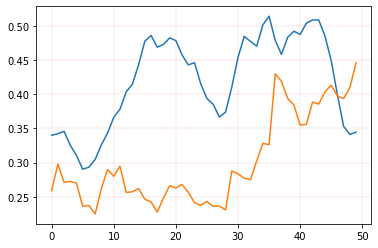

0 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>)


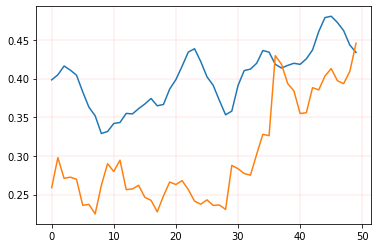

1 tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward>)


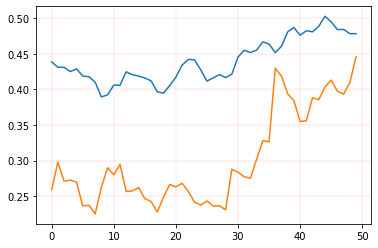

2 tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward>)


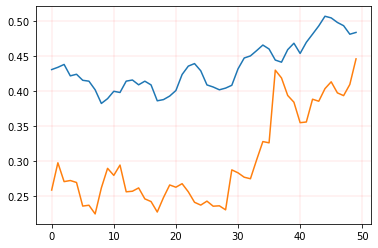

3 tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)


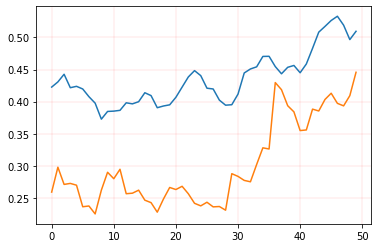

4 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>)


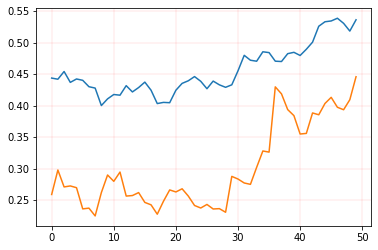

5 tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward>)


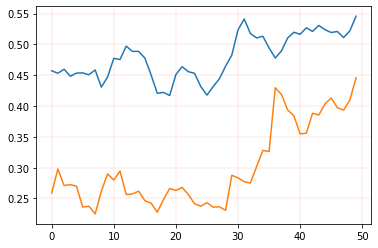

6 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)


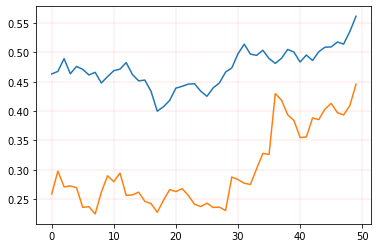

7 tensor(1.3485e-05, device='cuda:0', grad_fn=<MseLossBackward>)


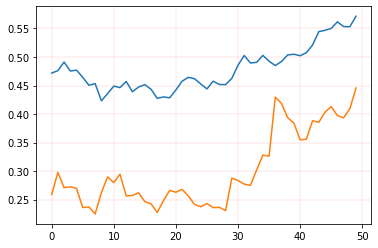

8 tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>)


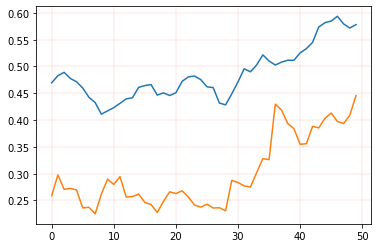

9 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>)


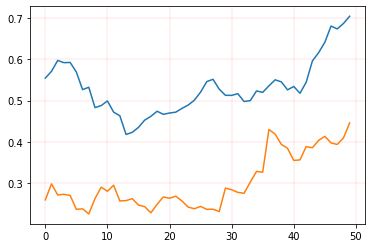

10 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>)


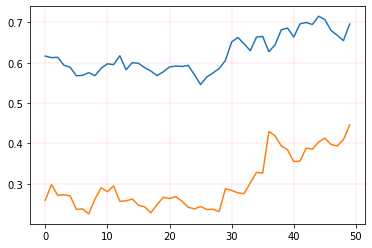

11 tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward>)


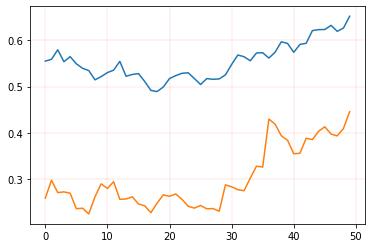

12 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)


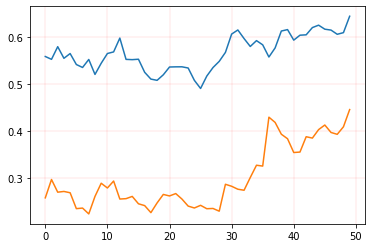

13 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)


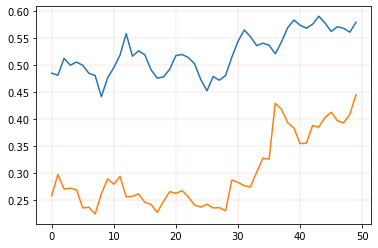

14 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


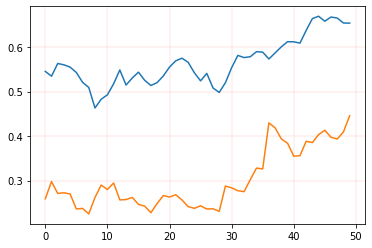

15 tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward>)


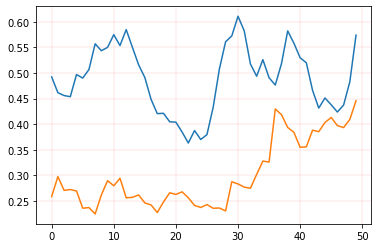

16 tensor(7.4933e-07, device='cuda:0', grad_fn=<MseLossBackward>)


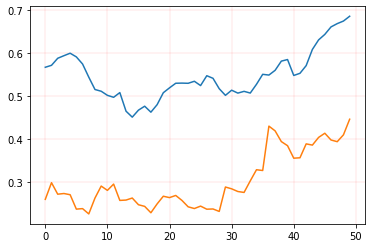

17 tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward>)


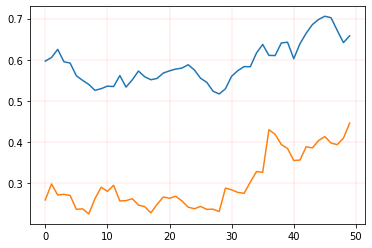

18 tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward>)


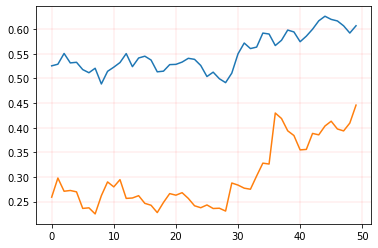

19 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>)


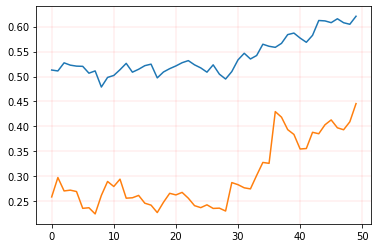

20 tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward>)


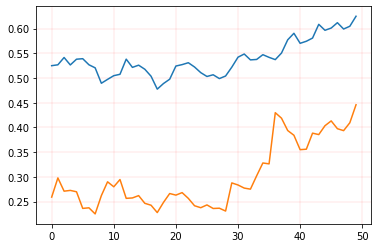

21 tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

In [31]:
# %%
epoch = 200
preds_in_learn = []
reals_in_learn = []
optimizer = torch.optim.Adam(instance.parameters(), lr=.0001)
for i in range(epoch):
    for seq, y in train_set:
        pred = instance.forward(seq)
        loss = criterion(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for item , y in test:
            preds_in_learn.append(instance.forward(item))
            reals_in_learn.append(y)
    plt.plot(range(50), preds_in_learn[-50:],)
    # plt.show()
    plt.grid(color='r', linestyle='-', linewidth=.1, zorder=.1)
    # plt.show()
    plt.plot(range(50), reals_in_learn[-50:])
    plt.show()
    preds_in_learn.clear()
    reals_in_learn.clear()
    print(i, loss)